# Preparing Raw Data

This is necessary to try any subsection of this Notebook, so execute it!

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [26]:
TESTED_MODES = np.arange(1, 33, dtype=int)
TESTED_MODES_FULL_ORDER = np.arange(1, 100, 5, dtype=int)
TRAIN_SPLIT = 2/3

In [27]:
np.random.seed(42)

In [28]:
collision_file = np.load(".data/Time_series_colisao.npz")
display(collision_file)
spreading_file = np.load(".data/Time_series_espalhamento.npz")
display(spreading_file)

NpzFile '.data/Time_series_colisao.npz' with keys: TS, Re, We, B

NpzFile '.data/Time_series_espalhamento.npz' with keys: TS, Re, We, Fr, V0...

In [29]:
collision_timesteps_raw = collision_file['TS']
display(f"Dimensions of the collision simulations: {collision_timesteps_raw.shape}")
display(f"That is, {collision_timesteps_raw.shape[0]} simulations, with {collision_timesteps_raw.shape[1]} timesteps each, having {collision_timesteps_raw.shape[2]} components each.")
spreading_timesteps_raw = spreading_file['TS']
display(f"Dimensions of the spreading simulations: {spreading_timesteps_raw.shape}")
display(f"That is, {spreading_timesteps_raw.shape[0]} simulations, with {spreading_timesteps_raw.shape[1]} timesteps each, having {spreading_timesteps_raw.shape[2]} components each.")

'Dimensions of the collision simulations: (72, 1000, 5)'

'That is, 72 simulations, with 1000 timesteps each, having 5 components each.'

'Dimensions of the spreading simulations: (132, 1000, 4)'

'That is, 132 simulations, with 1000 timesteps each, having 4 components each.'

# Collision component-wise order reduction

## Reordering data

We want to avoid mixing components in this case

In [ ]:
components_names = ['Diameter', 'Height', 'Kinetic Energy', 'Surface Energy', 'Dissipative Energy']
collision = dict()
for i, cn in enumerate(components_names):
    cn_dict = {}
    cn_dict['original_data'] = collision_timesteps_raw[:, :, i].T
    # (n_simulations, timesteps) [RAW]
    # (timesteps, n_simulations) [.T]
    collision[cn] = cn_dict

## Scaling

Firstly, we want to remove the "temporal mean", that is, the mean for each simulation of each component. After that, we can also scale the data so its standard variation is equal to 1:

$$\pmb{\hat{X}}=\sqrt{\frac{1}{n}}\left(\pmb{X}-\hat{x}1\right)$$

In [ ]:
from sklearn.preprocessing import StandardScaler

for key, obj in collision.items():
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(obj['original_data'])
    display(f"Asserting mean = 0 and std = 1 for component '{key}'")
    assert np.allclose(scaled_data.mean(axis=0), 0)
    assert np.allclose(scaled_data.std(axis=0), 1)
    display("Success!")
    obj['scaled_data'] = scaled_data
    obj['scaler'] = scaler

## Testing for all the given modes

In [ ]:
from sklearn.decomposition import PCA

NUMBER_OF_MODES = TESTED_MODES.shape[0]
for key, obj in collision.items():
    number_of_timesteps = obj['scaled_data'].shape[0]
    permutation_idx = np.random.permutation(number_of_timesteps)
    training_size = int(TRAIN_SPLIT * number_of_timesteps)
    training_idx = permutation_idx[:training_size]
    testing_idx = permutation_idx[training_size:]
    training_data = obj['original_data'][training_idx]
    training_data_scaled = obj['scaled_data'][training_idx]
    testing_data = obj['original_data'][testing_idx]
    testing_data_scaled = obj['scaled_data'][testing_idx]
    modes_mse = np.zeros((number_of_timesteps, NUMBER_OF_MODES))
    modes_mae = np.zeros_like(modes_mse)
    modes_mrae = np.zeros_like(modes_mse)
    for i, mode in enumerate(TESTED_MODES):
        # TRAINING DATA
        pca = PCA(n_components=mode, random_state=42)
        pca.fit(training_data_scaled)
        reconstructed_training_scaled = pca.inverse_transform(pca.transform(training_data_scaled))
        reconstructed_training = obj['scaler'].inverse_transform(reconstructed_training_scaled)
        mse_training = np.mean((training_data - reconstructed_training)**2, axis=1)
        mae_training = np.mean(np.abs(training_data - reconstructed_training), axis=1)
        mrae_training = np.mean(np.abs(training_data - reconstructed_training) / np.abs(training_data), axis=1)
        # TESTING DATA
        reconstructed_testing_scaled = pca.inverse_transform(pca.transform(testing_data_scaled))
        reconstructed_testing = obj['scaler'].inverse_transform(reconstructed_testing_scaled)
        mse_testing = np.mean((testing_data - reconstructed_testing)**2, axis=1)
        mae_testing = np.mean(np.abs(testing_data - reconstructed_testing), axis=1)
        mrae_testing = np.mean(np.abs(testing_data - reconstructed_testing) / np.abs(testing_data), axis=1)
        # STORING DATA
        modes_mse[training_idx, i] = mse_training
        modes_mae[training_idx, i] = mae_training
        modes_mrae[training_idx, i] = mrae_training
        modes_mse[testing_idx, i] = mse_testing
        modes_mae[testing_idx, i] = mae_testing
        modes_mrae[testing_idx, i] = mrae_testing
    training_error_idx = pd.Index(training_idx, name='Timestep')
    testing_error_idx = pd.Index(testing_idx, name='Timestep')
    columns = pd.MultiIndex.from_product([TESTED_MODES, ['MSE', 'MAE', 'MRAE']], names=['Modes', 'Metric'])
    training_error_data = np.zeros((training_error_idx.shape[0], NUMBER_OF_MODES * 3))
    testing_error_data = np.zeros((testing_error_idx.shape[0], NUMBER_OF_MODES * 3))
    training_error_data[:, ::3] = modes_mse[training_idx]
    training_error_data[:, 1::3] = modes_mae[training_idx]
    training_error_data[:, 2::3] = modes_mrae[training_idx]
    testing_error_data[:, ::3] = modes_mse[testing_idx]
    testing_error_data[:, 1::3] = modes_mae[testing_idx]
    testing_error_data[:, 2::3] = modes_mrae[testing_idx]
    training_error_df = pd.DataFrame(training_error_data, columns=columns, index=training_error_idx).sort_index()
    testing_error_df = pd.DataFrame(testing_error_data, columns=columns, index=testing_error_idx).sort_index()
    obj['permutation_idx'] = permutation_idx
    obj['training_idx'] = training_idx
    obj['testing_idx'] = testing_idx
    obj['training_error'] = training_error_df
    obj['testing_error'] = testing_error_df

## Showing these errors in graphs

In [ ]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.set_title("Mean relative absolute error for collision simulation components")
ax.set_xlabel("Number of modes")
ax.set_ylabel("Mean relative absolute error (MARE)")

for key, obj in collision.items():
    obj['training_error'].loc[:, (slice(None), 'MRAE')].mean().unstack().plot(ax=ax, linestyle='--', alpha=0.5)
    obj['testing_error'].loc[:, (slice(None), 'MRAE')].mean().unstack().plot(ax=ax, linestyle='-')

training_legend = [f"{key} (training)" for key in collision.keys()]
testing_legend = [f"{key} (testing)" for key in collision.keys()]
legend = [''] * (len(training_legend) + len(testing_legend))
legend[::2] = training_legend
legend[1::2] = testing_legend
ax.legend(legend)
fig.tight_layout()
fig.savefig(f".results/pca_error_modes_collision.png", dpi=200)
plt.show()

# Spreading component-wise order reduction

## Reordering data

We want to avoid mixing components in this case

In [ ]:
spreading_components_names = ['Diameter', 'Kinetic Energy', 'Surface Energy', 'Dissipative Energy']
spreading = dict()
for i, cn in enumerate(spreading_components_names):
    cn_dict = {}
    cn_dict['original_data'] = spreading_timesteps_raw[:, :, i].T
    # (n_simulations, timesteps) [RAW]
    # (timesteps, n_simulations) [.T]
    spreading[cn] = cn_dict

## Scaling

Firstly, we want to remove the "temporal mean", that is, the mean for each simulation of each component. After that, we can also scale the data so its standard variation is equal to 1:

$$\pmb{\hat{X}}=\sqrt{\frac{1}{n}}\left(\pmb{X}-\hat{x}1\right)$$

In [ ]:
from sklearn.preprocessing import StandardScaler

for key, obj in spreading.items():
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(obj['original_data'])
    display(f"Asserting mean = 0 and std = 1 for component '{key}'")
    assert np.allclose(scaled_data.mean(axis=0), 0)
    assert np.allclose(scaled_data.std(axis=0), 1)
    display("Success!")
    obj['scaled_data'] = scaled_data
    obj['scaler'] = scaler

## Testing for all the given modes

In [ ]:
from sklearn.decomposition import PCA

NUMBER_OF_MODES = TESTED_MODES.shape[0]
for key, obj in spreading.items():
    number_of_timesteps = obj['scaled_data'].shape[0]
    permutation_idx = np.random.permutation(number_of_timesteps)
    training_size = int(TRAIN_SPLIT * number_of_timesteps)
    training_idx = permutation_idx[:training_size]
    testing_idx = permutation_idx[training_size:]
    training_data = obj['original_data'][training_idx]
    training_data_scaled = obj['scaled_data'][training_idx]
    testing_data = obj['original_data'][testing_idx]
    testing_data_scaled = obj['scaled_data'][testing_idx]
    modes_mse = np.zeros((number_of_timesteps, NUMBER_OF_MODES))
    modes_mae = np.zeros_like(modes_mse)
    modes_mrae = np.zeros_like(modes_mse)
    for i, mode in enumerate(TESTED_MODES):
        # TRAINING DATA
        pca = PCA(n_components=mode)
        pca.fit(training_data_scaled)
        reconstructed_training_scaled = pca.inverse_transform(pca.transform(training_data_scaled))
        reconstructed_training = obj['scaler'].inverse_transform(reconstructed_training_scaled)
        mse_training = np.mean((training_data - reconstructed_training)**2, axis=1)
        mae_training = np.mean(np.abs(training_data - reconstructed_training), axis=1)
        mrae_training = np.mean(np.abs(training_data - reconstructed_training) / np.abs(training_data), axis=1)
        # TESTING DATA
        reconstructed_testing_scaled = pca.inverse_transform(pca.transform(testing_data_scaled))
        reconstructed_testing = obj['scaler'].inverse_transform(reconstructed_testing_scaled)
        mse_testing = np.mean((testing_data - reconstructed_testing)**2, axis=1)
        mae_testing = np.mean(np.abs(testing_data - reconstructed_testing), axis=1)
        mrae_testing = np.mean(np.abs(testing_data - reconstructed_testing) / np.abs(testing_data), axis=1)
        # STORING DATA
        modes_mse[training_idx, i] = mse_training
        modes_mae[training_idx, i] = mae_training
        modes_mrae[training_idx, i] = mrae_training
        modes_mse[testing_idx, i] = mse_testing
        modes_mae[testing_idx, i] = mae_testing
        modes_mrae[testing_idx, i] = mrae_testing
    training_error_idx = pd.Index(training_idx, name='Timestep')
    testing_error_idx = pd.Index(testing_idx, name='Timestep')
    columns = pd.MultiIndex.from_product([TESTED_MODES, ['MSE', 'MAE', 'MRAE']], names=['Modes', 'Metric'])
    training_error_data = np.zeros((training_error_idx.shape[0], NUMBER_OF_MODES * 3))
    testing_error_data = np.zeros((testing_error_idx.shape[0], NUMBER_OF_MODES * 3))
    training_error_data[:, ::3] = modes_mse[training_idx]
    training_error_data[:, 1::3] = modes_mae[training_idx]
    training_error_data[:, 2::3] = modes_mrae[training_idx]
    testing_error_data[:, ::3] = modes_mse[testing_idx]
    testing_error_data[:, 1::3] = modes_mae[testing_idx]
    testing_error_data[:, 2::3] = modes_mrae[testing_idx]
    training_error_df = pd.DataFrame(training_error_data, columns=columns, index=training_error_idx).sort_index()
    testing_error_df = pd.DataFrame(testing_error_data, columns=columns, index=testing_error_idx).sort_index()
    obj['permutation_idx'] = permutation_idx
    obj['training_idx'] = training_idx
    obj['testing_idx'] = testing_idx
    obj['training_error'] = training_error_df
    obj['testing_error'] = testing_error_df

## Showing these errors in graphs

In [ ]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.set_title("Mean relative absolute error for spreading simulation components")
ax.set_xlabel("Number of modes")
ax.set_ylabel("Mean relative absolute error (MARE)")

for key, obj in spreading.items():
    obj['training_error'].loc[:, (slice(None), 'MRAE')].mean().unstack().plot(ax=ax, linestyle='--', alpha=0.5)
    obj['testing_error'].loc[:, (slice(None), 'MRAE')].mean().unstack().plot(ax=ax, linestyle='-')

training_legend = [f"{key} (training)" for key in spreading.keys()]
testing_legend = [f"{key} (testing)" for key in spreading.keys()]
legend = [''] * (len(training_legend) + len(testing_legend))
legend[::2] = training_legend
legend[1::2] = testing_legend
ax.legend(legend)
fig.tight_layout()
fig.savefig(f".results/pca_error_modes_spreading.png", dpi=200)

# Collision full order reduction

## Reordering data and rescaling energies

In [ ]:
collision_timesteps_components_last = np.transpose(collision_timesteps_raw, (1, 0, 2))
display(f"Shape after transpose is: {collision_timesteps_components_last.shape}")
# We want to rescale the energies (3rd, 4th and 5th components) in a way that its sum is 1
# By doing this, we can rule out the magnitude effect of the energies
# First, let's save these magnitudes
# collision_timesteps_components_last_energies = collision_timesteps_components_last[:, :, 2:].sum(axis=-1)
# # Now, let's divide the energies by their sum
# collision_timesteps_components_last[:, :, 2:] = (
#     collision_timesteps_components_last[:, :, 2:] /
#     collision_timesteps_components_last_energies[:, :, np.newaxis]
# )
# Flattening 2nd and 3rd dimensions
collision_timesteps_components_last = (
    collision_timesteps_components_last
    .reshape(collision_timesteps_components_last.shape[0], -1)
)
display(f"Shape after flattening is: {collision_timesteps_components_last.shape}")
collision_full = {}
collision_full['original_data'] = collision_timesteps_components_last

## Scaling

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_data = scaler.fit_transform(collision_full['original_data'])
display(f"Asserting mean = 0 and std = 1 for every column")
assert np.allclose(scaled_data.mean(axis=0), 0)
assert np.allclose(scaled_data.std(axis=0), 1)
display("Success!")
collision_full['scaled_data'] = scaled_data
collision_full['scaler'] = scaler

## Testing every mode

In [ ]:
from sklearn.decomposition import PCA

NUMBER_OF_MODES = TESTED_MODES_FULL_ORDER.shape[0]
number_of_timesteps = collision_full['scaled_data'].shape[0]
permutation_idx = np.random.permutation(number_of_timesteps)
training_size = int(TRAIN_SPLIT * number_of_timesteps)
training_idx = permutation_idx[:training_size]
testing_idx = permutation_idx[training_size:]
training_data = collision_full['original_data'][training_idx]
training_data_scaled = collision_full['scaled_data'][training_idx]
testing_data = collision_full['original_data'][testing_idx]
testing_data_scaled = collision_full['scaled_data'][testing_idx]
modes_mse = np.zeros((number_of_timesteps, NUMBER_OF_MODES))
modes_mae = np.zeros_like(modes_mse)
modes_mrae = np.zeros_like(modes_mse)
for i, mode in enumerate(TESTED_MODES_FULL_ORDER):
    # TRAINING DATA
    pca = PCA(n_components=mode, random_state=42)
    pca.fit(training_data_scaled)
    reconstructed_training_scaled = pca.inverse_transform(pca.transform(training_data_scaled))
    reconstructed_training = collision_full['scaler'].inverse_transform(reconstructed_training_scaled)
    mse_training = np.mean((training_data - reconstructed_training)**2, axis=1)
    mae_training = np.mean(np.abs(training_data - reconstructed_training), axis=1)
    mrae_training = np.mean(np.abs(training_data - reconstructed_training) / np.abs(training_data), axis=1)
    # TESTING DATA
    reconstructed_testing_scaled = pca.inverse_transform(pca.transform(testing_data_scaled))
    reconstructed_testing = collision_full['scaler'].inverse_transform(reconstructed_testing_scaled)
    mse_testing = np.mean((testing_data - reconstructed_testing)**2, axis=1)
    mae_testing = np.mean(np.abs(testing_data - reconstructed_testing), axis=1)
    mrae_testing = np.mean(np.abs(testing_data - reconstructed_testing) / np.abs(testing_data), axis=1)
    # STORING DATA
    modes_mse[training_idx, i] = mse_training
    modes_mae[training_idx, i] = mae_training
    modes_mrae[training_idx, i] = mrae_training
    modes_mse[testing_idx, i] = mse_testing
    modes_mae[testing_idx, i] = mae_testing
    modes_mrae[testing_idx, i] = mrae_testing
training_error_idx = pd.Index(training_idx, name='Timestep')
testing_error_idx = pd.Index(testing_idx, name='Timestep')
columns = pd.MultiIndex.from_product([TESTED_MODES_FULL_ORDER, ['MSE', 'MAE', 'MRAE']], names=['Modes', 'Metric'])
training_error_data = np.zeros((training_error_idx.shape[0], NUMBER_OF_MODES * 3))
testing_error_data = np.zeros((testing_error_idx.shape[0], NUMBER_OF_MODES * 3))
training_error_data[:, ::3] = modes_mse[training_idx]
training_error_data[:, 1::3] = modes_mae[training_idx]
training_error_data[:, 2::3] = modes_mrae[training_idx]
testing_error_data[:, ::3] = modes_mse[testing_idx]
testing_error_data[:, 1::3] = modes_mae[testing_idx]
testing_error_data[:, 2::3] = modes_mrae[testing_idx]
training_error_df = pd.DataFrame(training_error_data, columns=columns, index=training_error_idx).sort_index()
testing_error_df = pd.DataFrame(testing_error_data, columns=columns, index=testing_error_idx).sort_index()
collision_full['permutation_idx'] = permutation_idx
collision_full['training_idx'] = training_idx
collision_full['testing_idx'] = testing_idx
collision_full['training_error'] = training_error_df
collision_full['testing_error'] = testing_error_df

## Graphing

In [ ]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.set_title("Mean relative absolute error in collision simulation full order reduction")
ax.set_xlabel("Number of modes")
ax.set_ylabel("Mean relative absolute error (MRAE)")

collision_full['training_error'].loc[:, (slice(None), 'MRAE')].mean().unstack().plot(ax=ax, linestyle='--', alpha=0.5)
collision_full['testing_error'].loc[:, (slice(None), 'MRAE')].mean().unstack().plot(ax=ax, linestyle='-')

ax.legend(['Training', 'Testing'])
fig.tight_layout()
fig.savefig(f".results/pca_error_modes_collision_full.png", dpi=200)
plt.show()

# Spreading full order reduction

## Reordering data and rescaling energies

In [30]:
spreading_timesteps_components_last = np.transpose(spreading_timesteps_raw, (1, 0, 2))
display(f"Shape after transpose is: {spreading_timesteps_components_last.shape}")
# We want to rescale the energies (2nd, 3rd and 4th components) in a way that its sum is 1
# By doing this, we can rule out the magnitude effect of the energies
# First, let's save these magnitudes
# spreading_timesteps_components_last_energies = spreading_timesteps_components_last[:, :, 1:].sum(axis=-1)
# # Now, let's divide the energies by their sum
# spreading_timesteps_components_last[:, :, 1:] = (
#     spreading_timesteps_components_last[:, :, 1:] /
#     spreading_timesteps_components_last_energies[:, :, np.newaxis]
# )
# Flattening 2nd and 3rd dimensions
spreading_timesteps_components_last = (
    spreading_timesteps_components_last
    .reshape(spreading_timesteps_components_last.shape[0], -1)
)
display(f"Shape after flattening is: {spreading_timesteps_components_last.shape}")
spreading_full = {}
spreading_full['original_data'] = spreading_timesteps_components_last

'Shape after transpose is: (1000, 132, 4)'

'Shape after flattening is: (1000, 528)'

## Scaling

In [31]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_data = scaler.fit_transform(spreading_full['original_data'])
display(f"Asserting mean = 0 and std = 1 for every column")
assert np.allclose(scaled_data.mean(axis=0), 0)
assert np.allclose(scaled_data.std(axis=0), 1)
display("Success!")
spreading_full['scaled_data'] = scaled_data
spreading_full['scaler'] = scaler

'Asserting mean = 0 and std = 1 for every column'

'Success!'

## Testing every mode

In [32]:
from sklearn.decomposition import PCA

NUMBER_OF_MODES = TESTED_MODES_FULL_ORDER.shape[0]
number_of_timesteps = spreading_full['scaled_data'].shape[0]
permutation_idx = np.random.permutation(number_of_timesteps)
training_size = int(TRAIN_SPLIT * number_of_timesteps)
training_idx = permutation_idx[:training_size]
testing_idx = permutation_idx[training_size:]
training_data = spreading_full['original_data'][training_idx]
training_data_scaled = spreading_full['scaled_data'][training_idx]
testing_data = spreading_full['original_data'][testing_idx]
testing_data_scaled = spreading_full['scaled_data'][testing_idx]
modes_mse = np.zeros((number_of_timesteps, NUMBER_OF_MODES))
modes_mae = np.zeros_like(modes_mse)
modes_mrae = np.zeros_like(modes_mse)
for i, mode in enumerate(TESTED_MODES_FULL_ORDER):
    # TRAINING DATA
    pca = PCA(n_components=mode, random_state=42)
    pca.fit(training_data_scaled)
    reconstructed_training_scaled = pca.inverse_transform(pca.transform(training_data_scaled))
    reconstructed_training = spreading_full['scaler'].inverse_transform(reconstructed_training_scaled)
    mse_training = np.mean((training_data - reconstructed_training)**2, axis=1)
    mae_training = np.mean(np.abs(training_data - reconstructed_training), axis=1)
    mrae_training = np.mean(np.abs(training_data - reconstructed_training) / np.abs(training_data), axis=1)
    # TESTING DATA
    reconstructed_testing_scaled = pca.inverse_transform(pca.transform(testing_data_scaled))
    reconstructed_testing = spreading_full['scaler'].inverse_transform(reconstructed_testing_scaled)
    mse_testing = np.mean((testing_data - reconstructed_testing)**2, axis=1)
    mae_testing = np.mean(np.abs(testing_data - reconstructed_testing), axis=1)
    mrae_testing = np.mean(np.abs(testing_data - reconstructed_testing) / np.abs(testing_data), axis=1)
    # STORING DATA
    modes_mse[training_idx, i] = mse_training
    modes_mae[training_idx, i] = mae_training
    modes_mrae[training_idx, i] = mrae_training
    modes_mse[testing_idx, i] = mse_testing
    modes_mae[testing_idx, i] = mae_testing
    modes_mrae[testing_idx, i] = mrae_testing
training_error_idx = pd.Index(training_idx, name='Timestep')
testing_error_idx = pd.Index(testing_idx, name='Timestep')
columns = pd.MultiIndex.from_product([TESTED_MODES_FULL_ORDER, ['MSE', 'MAE', 'MRAE']], names=['Modes', 'Metric'])
training_error_data = np.zeros((training_error_idx.shape[0], NUMBER_OF_MODES * 3))
testing_error_data = np.zeros((testing_error_idx.shape[0], NUMBER_OF_MODES * 3))
training_error_data[:, ::3] = modes_mse[training_idx]
training_error_data[:, 1::3] = modes_mae[training_idx]
training_error_data[:, 2::3] = modes_mrae[training_idx]
testing_error_data[:, ::3] = modes_mse[testing_idx]
testing_error_data[:, 1::3] = modes_mae[testing_idx]
testing_error_data[:, 2::3] = modes_mrae[testing_idx]
training_error_df = pd.DataFrame(training_error_data, columns=columns, index=training_error_idx).sort_index()
testing_error_df = pd.DataFrame(testing_error_data, columns=columns, index=testing_error_idx).sort_index()
spreading_full['permutation_idx'] = permutation_idx
spreading_full['training_idx'] = training_idx
spreading_full['testing_idx'] = testing_idx
spreading_full['training_error'] = training_error_df
spreading_full['testing_error'] = testing_error_df

## Graphing

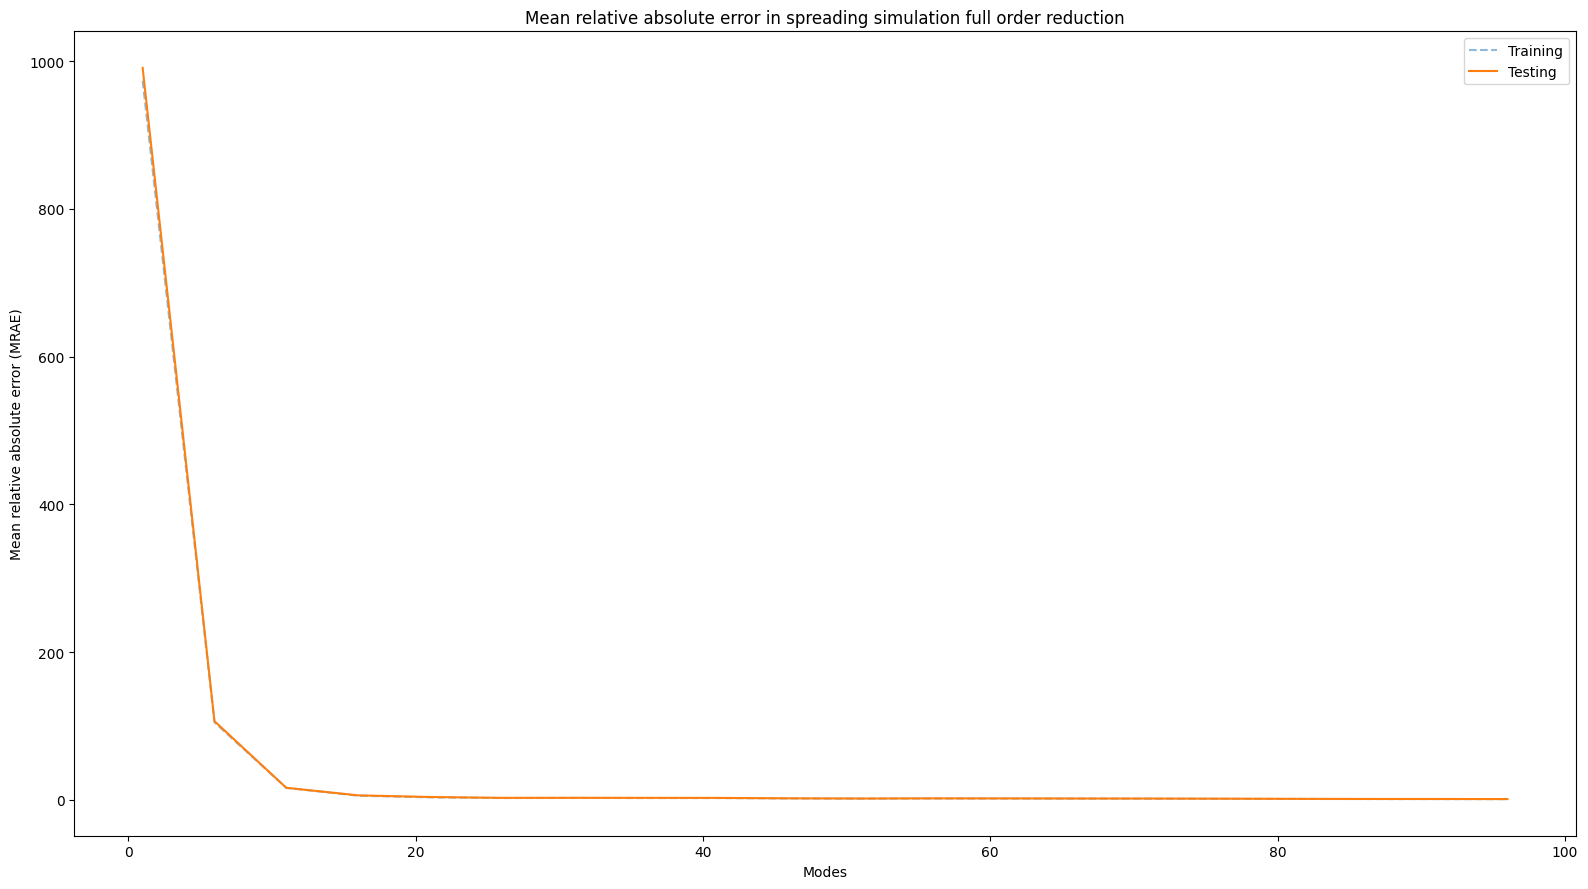

In [33]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.set_title("Mean relative absolute error in spreading simulation full order reduction")
ax.set_xlabel("Number of modes")
ax.set_ylabel("Mean relative absolute error (MRAE)")

spreading_full['training_error'].loc[:, (slice(None), 'MRAE')].mean().unstack().plot(ax=ax, linestyle='--', alpha=0.5)
spreading_full['testing_error'].loc[:, (slice(None), 'MRAE')].mean().unstack().plot(ax=ax, linestyle='-')

ax.legend(['Training', 'Testing'])
fig.tight_layout()
fig.savefig(f".results/pca_error_modes_spreading_full.png", dpi=200)
plt.show()